# 텍스트 분석

## 8.8 문서 유사도

#### 문서 유사도 측정 방법 - 코사인 유사도
- 문서와 문서 간의 유사도 비교는 일반적으로 코사인 유사도를 사용(벡터의 상호 방향성이 얼마나 유사한지에 기반)
- 코사인 유사도가 문서의 유사도에 많이 사용되는 이뉴는 희소 행렬에서도 적용이 가능하고 정확도가 덜 떨어지기 때문(EX - 유클리드 거리보다)

#### 두 벡터 사잇각
- 두 벡터의 사잇각에 따라서 상호 관계는 유사하거나 관련이 없거나 아예 반대 관계가 될 수 있음

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list) # 유사도 비교를 위해 벡터화된 행렬로 변환
print(feature_vect_simple.shape)

(3, 18)


In [3]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector  추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [4]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [7]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


#### Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [8]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [9]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'C:\Users\Yoo\Documents\Study\Machine_Learning_Perfect_Guide\data\topics' 
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair) # 호텔 군집화내의 코사인 유사도(기준행 0)

호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')
##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo  와 타 문서 유사도######
[[1.         0.0430688  0.05221059 0.06189595 0.05846178 0.06193118
  0.03638665 0.11742762 0.38038865 0.32619948 0.51442299 0.11282857
  0.13989623 0.1386783  0.09518068 0.07049362]]


Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

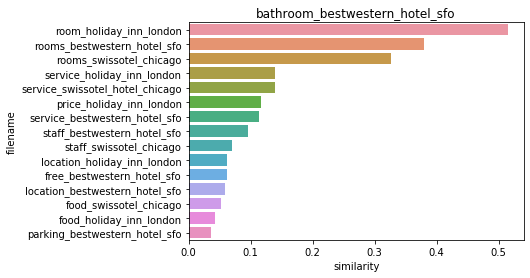

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)

## 8.9 한글 텍스트 처리 - 네이버 영화 평점 감성 분석

#### 한글 NLP 처리의 어려움
- 띄어쓰기와 다양한 조사로 인하여 한글의 언어 처리는 영어보다 어려움

#### KoNLPy 소개
- KoNLPy는 파이썬의 대표적인 한글 형태소 패키지(형태소는 '단어로서 의미를 가지는 최소 단위'로 정의할 수 있음)
- 형태소 분석이란 말뭉치를 이러한 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅을 부착하는 작업을 일반적으로 지칭

In [12]:
import pandas as pd

train_df = pd.read_csv('./data/rating/ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [13]:
train_df['label'].value_counts() # 균등한 분포를 가짐

0    75173
1    74827
Name: label, dtype: int64

In [14]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용하여 숫자를 공백으로 변경(정규 표현식으로 \d 는 숫자를 의미함.) 
train_df['document'] = train_df['document'].apply( lambda x : re.sub(r"\d+", " ", x))

# 테스트 데이터 셋을 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('./data/rating/ratings_train.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply( lambda x : re.sub(r"\d+", " ", x))

In [15]:
# 형태소 단어 토큰화
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
    # 입력 인자로 들어온 text 를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = twitter.morphs(text) # morphs ==> 입력 인자로 들어온 문장을 형태소 단어 형태로 토큰화하여 list 객체로 반환
    return tokens_ko

C:\Users\Yoo\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [16]:
# TF-IDF 피처 모델 생성
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2) 
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [17]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행. 
lg_clf = LogisticRegression(random_state=0)

# Parameter C 최적화를 위해 GridSearchCV 를 이용. 
params = {'C': [1 ,3.5, 4.5, 5.5, 10 ]}
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=3 ,scoring='accuracy', verbose=1 )
grid_cv.fit(tfidf_matrix_train , train_df['label'])
print(grid_cv.best_params_ , round(grid_cv.best_score_,4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

{'C': 3.5} 0.8592


C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용하여 테스트 데이터를 TF-IDF 값으로 Feature 변환함. 
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier 는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ',accuracy_score(test_df['label'],preds))

Logistic Regression 정확도:  0.9416666666666667


## 8.10 텍스트 분석 실습 - 캐글 Mercary Price Suggestion Challenge(데이터가 커서 실행은 X)
- 일본의 대형 온라인 쇼핑몰인 Mercary사의 제품에 대해 가격을 예측하는 과제

#### 데이터 전처리

In [19]:
# 데이터 개략적 정보 확인
"""
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3) # 1482535개의 레코드를 가진 데이터
"""

"\nfrom sklearn.linear_model import Ridge , LogisticRegression\nfrom sklearn.model_selection import train_test_split , cross_val_score\nfrom sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer\nimport pandas as pd\n\nmercari_df= pd.read_csv('mercari_train.tsv',sep='\t')\nprint(mercari_df.shape)\nmercari_df.head(3) # 1482535개의 레코드를 가진 데이터\n"

In [20]:
# 데이터 개략적 정보 확인
"""
print(mercari_df.info()) # brand_name 칼럼의 경우 중요 피처로 판단되나 매우 많은 null 값이 존재
"""

'\nprint(mercari_df.info()) # brand_name 칼럼의 경우 중요 피처로 판단되나 매우 많은 null 값이 존재\n'

In [21]:
# 타깃의 분포 확인
"""
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False) # 타깃은 매우 왜곡된 분포를 가짐(조정이 필요)
"""

"\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n%matplotlib inline\n\ny_train_df = mercari_df['price']\nplt.figure(figsize=(6,4))\nsns.distplot(y_train_df,kde=False) # 타깃은 매우 왜곡된 분포를 가짐(조정이 필요)\n"

In [22]:
# 타깃의 변화된 분포 확인
"""
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False) # 비교적 고른 분포를 갖게 됨
"""

'\nimport numpy as np\n\ny_train_df = np.log1p(y_train_df)\nsns.distplot(y_train_df,kde=False) # 비교적 고른 분포를 갖게 됨\n'

In [23]:
# 타깃 변환된 값 확인
"""
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)
"""

"\nmercari_df['price'] = np.log1p(mercari_df['price'])\nmercari_df['price'].head(3)\n"

In [24]:
# 다른 피처들 살펴보기
"""
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())
"""

"\nprint('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())\nprint('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())\n"

In [25]:
# item_description 피처 확인
"""
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count() # null은 적으나 비슷한 의미인 설명 없음이 매우 많음
"""

"\nboolean_cond= mercari_df['item_description']=='No description yet'\nmercari_df[boolean_cond]['item_description'].count() # null은 적으나 비슷한 의미인 설명 없음이 매우 많음\n"

In [26]:
# category_name 피처 대, 중, 소 피처로 분할
"""
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())
"""

"\n# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환\ndef split_cat(category_name):\n    try:\n        return category_name.split('/')\n    except:\n        return ['Other_Null' , 'Other_Null' , 'Other_Null']\n\n# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. \nmercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] =                         zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))\n\n# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출\nprint('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())\nprint('중분류 갯수 :', mercari_df['cat_jung'].nunique())\nprint('소분류 갯수 :', mercari_df['cat_so'].nunique())\n"

In [27]:
"""
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()
"""

"\nmercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')\nmercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')\nmercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')\n\n# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.\nmercari_df.isnull().sum()\n"

#### 피처 인코딩과 피처 벡터화
- 이 데이터에서 이용되는 데이터 세트는 문자열 칼럼이 많으므로 원-핫 인코딩을 수행하거나 피처 벡터화로 컬럼을 선별
- 다만, 선형 회귀에서 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용
- 피처 벡터화의 경우는 비교적 짧은 텍스트는 Count 기반의 벡터화를, 긴 텍스트는 TD-IDF 기반의 벡터화를 적용

In [28]:
# brand_name 변수 확인
"""
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique()) # 4810건으로 많으나 원-핫 인코딩 적용
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5]) # 대부분이 문자열로 처리되어 있음
"""

"\nprint('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())\nprint('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])\n"

In [29]:
# name 변수 확인
"""
print('name 의 종류 갯수 :', mercari_df['name'].nunique()) # 종류가 백만 가지가 넘음(대부분 고유한 제품이란 의미)
print('name sample 7건 : \n', mercari_df['name'][:7]) # 종류가 너무 많으므로 Count 기반의 피처 벡터화를 적용
"""
# category_name은 이전에 대, 중, 소로 분할됐으므로 원-핫 인코딩 적용
# shipping은 배송비 무료 여부로 두 가지 유형을 갖고 있고, item_condition_id는 다섯 가지의 유형이므로 모두 원-핫 인코딩을 적용

"\nprint('name 의 종류 갯수 :', mercari_df['name'].nunique()) # 종류가 백만 가지가 넘음(대부분 고유한 제품이란 의미)\nprint('name sample 7건 : \n', mercari_df['name'][:7]) # 종류가 너무 많으므로 Count 기반의 피처 벡터화를 적용\n"

In [30]:
# item_description 변수 확인
"""
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2] # 평균 문자열이 145자로 비교적 크므로 TF-IDF로 변환
"""

"\npd.set_option('max_colwidth', 200)\n\n# item_description의 평균 문자열 개수\nprint('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())\n\nmercari_df['item_description'][:2] # 평균 문자열이 145자로 비교적 크므로 TF-IDF로 변환\n"

In [31]:
# Count, TF-IDF 변환
"""
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)
"""

"\n# name 속성에 대한 feature vectorization 변환\ncnt_vec = CountVectorizer()\nX_name = cnt_vec.fit_transform(mercari_df.name)\n\n# item_description 에 대한 feature vectorization 변환 \ntfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')\nX_descp = tfidf_descp.fit_transform(mercari_df['item_description'])\n\nprint('name vectorization shape:',X_name.shape)\nprint('item_description vectorization shape:',X_descp.shape)\n"

- CountVectorizer, TfidfVectorizer를 통해 반환되는 데이터는 희소 행렬로 다른 데이터와 결합되어 데이터 세트로 구성해야 함
- 이를 위해서는 이 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤 결합하는 방식을 적용
- 사이킷런은 원-핫 인코딩을 위해 OneHotEncoder와 LabelBinarizer 클래스를 제공
- 이 중 LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원(생성 시 sparse_out = True로 설정하면 됨)
- 따라서, 모든 인코딩 대상 칼럼은 LabelBinarizer를 이용해 희소 행렬 형태의 원-핫 인코딩으로 변환
- 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용해 결합

In [32]:
"""
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])
"""

"\nfrom sklearn.preprocessing import LabelBinarizer\n\n# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환\nlb_brand_name= LabelBinarizer(sparse_output=True)\nX_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])\n\nlb_item_cond_id = LabelBinarizer(sparse_output=True)\nX_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])\n\nlb_shipping= LabelBinarizer(sparse_output=True)\nX_shipping = lb_shipping.fit_transform(mercari_df['shipping'])\n\n# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환\nlb_cat_dae = LabelBinarizer(sparse_output=True)\nX_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])\n\nlb_cat_jung = LabelBinarizer(sparse_output=True)\nX_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])\n\nlb_cat_so = LabelBinarizer(sparse_output=True)\nX_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])\n"

In [33]:
# 인코딩 결과 확인(반환된 행렬은 CSR 형태)
"""
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))
"""

"\nprint(type(X_brand), type(X_item_cond_id), type(X_shipping))\nprint('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))\nprint('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))\nprint('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))\n"

In [34]:
# 변환된 데이터 결합
"""
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape) # 결합된 데이터는 (1482535, 161569)의 Shape

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()
"""

'\nfrom  scipy.sparse import hstack\nimport gc\n\nsparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,\n            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)\n\n# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. \nX_features_sparse= hstack(sparse_matrix_list).tocsr()\nprint(type(X_features_sparse), X_features_sparse.shape)\n\n# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. \ndel X_features_sparse\ngc.collect()\n'

#### 릿지 회귀 모델 구축 평가

In [35]:
# 분석 평가 함수 및 변환 함수(타깃을 log1p() 했으므로) 생성
"""
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result
"""

'\ndef rmsle(y , y_pred):\n    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 \n    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))\n\ndef evaluate_org_price(y_test , preds): \n    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. \n    preds_exmpm = np.expm1(preds)\n    y_test_exmpm = np.expm1(y_test)\n    \n    # rmsle로 RMSLE 값 추출\n    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)\n    return rmsle_result\n'

In [36]:
# 모델 적용 및 평가 함수 생성
"""
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test
"""

"\nimport gc \nfrom  scipy.sparse import hstack\n\ndef model_train_predict(model,matrix_list):\n    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합\n    X= hstack(matrix_list).tocsr()     \n    \n    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)\n    \n    # 모델 학습 및 예측\n    model.fit(X_train , y_train)\n    preds = model.predict(X_test)\n    \n    del X , X_train , X_test , y_train \n    gc.collect()\n    \n    return preds , y_test\n"

In [37]:
# 성능 평가
"""
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds)) # Item Description가 중요한 변수임을 알 수 있음
"""

'\nlinear_model = Ridge(solver = "lsqr", fit_intercept=False)\n\nsparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)\nlinear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)\nprint(\'Item Description을 제외했을 때 rmsle 값:\', evaluate_org_price(y_test , linear_preds))\n\nsparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)\nlinear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)\nprint(\'Item Description을 포함한 rmsle 값:\',  evaluate_org_price(y_test ,linear_preds)) # Item Description가 중요한 변수임을 알 수 있음\n'

#### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [38]:
# LGBM으로 예측
"""
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))
"""

"\nfrom lightgbm import LGBMRegressor\n\nsparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)\n\nlgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)\nlgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)\nprint('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))\n"

In [39]:
# 릿지와 LGBM 앙상블을 통한 예측
"""
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))
"""

"\npreds = lgbm_preds * 0.45 + linear_preds * 0.55\nprint('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))\n"